# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **
Given a student's data, we need to predict an outcome from a finite discreet set of {`success`, `failure`} which makes this a classification problem. On the other hand, if we were asked to predict how many marks a given student might score in the final exam, I would treat that as a regression problem because I am predicting a continuous variable. 

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [51]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [79]:
# Calculate number of students
n_students = student_data.shape[0]

# Calculate number of features
n_features = student_data.shape[1] - 1 #the last column 'passed' is target variable not a feature

# Calculate passing students
n_passed = len(student_data[student_data.passed=='yes'])

# Calculate failing students
n_failed = len(student_data[student_data.passed=='no'])

# Calculate graduation rate
grad_rate = (float(n_passed)/n_students)*100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [53]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [54]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [80]:
# Import any additional functionality you may need here
from sklearn import cross_validation

# Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, test_size=num_test, random_state=42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

### Gaussian Naive Bayes (GaussianNB):  <font color='red'>(Not chosen for this problem)</font>
GaussianNB assumes conditional independence between features given class label. This may not be true in our case. For example weather student has access to internet might depend a lot on jobs of studen's parent. 

* **Real world application:** 
* **Strengths:** 
    * Scalable
* **Weaknesses:**  
    * Assumes independence between features. 
    * Can’t learn interactions between features.
* **Why not a good candidate for this problem:** 

### Decision Tree:  <font color='green'>(Chosen for this problem)</font>
* **Real world application:** 
    * Star classification 
    * Medical diagnosis 
    * Credit risk analysis 

* **Strengths:** 
    * Can handle inter-feature interactions easily
    * Data need not be linearly separable
    * High learning speed 
    * Robust
    * Insensitive towards noise and missing values.

* **Weaknesses:** 
    * Doesn’t support online learning; Need to rebuild the when new features/data is added.
    * Can overfit to training data easily. 
* **Why a good candidate for this problem:** 


### Bagging Classifier: <font color='red'>(Not chosen for this problem)</font>
* **Real world application:** 
* **Strengths:** 
* **Weaknesses:**  
    * Time consuming; Slow learning speed.
    * Hard to understand
* **Why not a good candidate for this problem:** 

### RandomForestClassifier: <font color='red'>(Not chosen for this problem)</font>
* **Real world application:** 
* **Strengths:** 
* **Weaknesses:**  
    * Can parallelize the learning process as the trees are train independently
* **Why not a good candidate for this problem:** 

As we have seen that we need a model that is more complex(with higher variance) than a single Decision Tree. And, 
RandomForest is bagging based ensemble of decision trees that aims to decrese variance. We are not going to explore RandomForest hyet. 
  If we had more data, we could explore increasing complexity of a single decision tree by tuning its parameters and then reducing the overfit by ensemble technique. 
  
# Boosting
Decision Tree with depth 1 is not overfitting. The testing and training accuracy peak at 80%, which is not high. This makes think that we need a more complex model. We have to increase variance without overfitting. Boosting is an option we can explore. This also rules out RandomForestClassifier. 

### Ada Boost: <font color='green'>(Chosen for this problem)</font>
* **Real world application:** 
* **Strengths:** 
* **Weaknesses:** 
    * Doesn’t support online learning
* **Why a good candidate for this problem:** 


### Gradient Boost: <font color='red'>(Not chosen for this problem)</font>
* **Real world application:** 
* **Strengths:** 
* **Weaknesses:**
    * Can overfit; So, need to find good stopping point. 
* **Why not a good candidate for this problem:** 


### K-Nearest Neighbors (KNeighbors): <font color='red'>(Not chosen for this problem)</font>
* **Real world application:** 
    * Computer Vision
    * Facial recognition
* **Strengths:** 
    * Simple
* **Weaknesses:**  
    * Sensitive to local structure of data. 
    * Memory intensive 
    * Sensitive to noise
* **Why not a good candidate for this problem:** 


### Stochastic Gradient Descent (SGDC): <font color='red'>(Not chosen for this problem)</font>
* **Real world application:** 
* **Strengths:** 
    * Efficient
    * Easy to implement
    * Scales well with large training set
* **Weaknesses:**  
    * Needs lot of training data.
    * Memory intensive 
    * Sensitive to noise 
    * Has many hyperparameters
    * Sensitive to feature scaling 
* **Why not a good candidate for this problem:** 


### Support Vector Machines (SVM): <font color='green'>(Chosen for this problem)</font>
* **Real world application:** 
    * Popular in text classification as they are high dimensional 
    * Text and hypertext categorization as their application can significantly reduce the need for labeled training instances in both the standard inductive and transductive settings.
    * Handwritten characters can be recognized using SVM
    * Biological and other sciences: They have been used to classify proteins with up to 90% of the compounds classified correctly.
* **Strengths:** 
    * High accuracy 
    * Theoretical guarantees regarding overfitting 
    * Data need not be linearly separable if kernel(a similarity measuring function) is used.
* **Weaknesses:**  
    * Memory intensive because the model has to remember the support vectors to for prediction.
    * Doesn’t support online learning
    * Hard to interpret 
    * Difficult to run and tune when data is large. 
    * The choice of kernel function is crucial for the success of all kernel algorithms because the kernel constitutes prior knowledge that is available about a task.

* **Why a good candidate for this problem:** 


### Logistic Regression: <font color='red'>(Not chosen for this problem)</font>
* **Real world application:** 
* **Strengths:** 
    * Supports online learning
* **Weaknesses:**  
* **Why not a good candidate for this problem:** 



### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [56]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    #print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    #print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    #print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    train_acc = predict_labels(clf, X_train, y_train)
    #print "F1 score for training set: {:.4f}.".format(train_acc)
    test_acc = predict_labels(clf, X_test, y_test)
    #print "F1 score for test set: {:.4f}.".format(test_acc)
    return train_acc,test_acc

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [58]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

(0, 1)

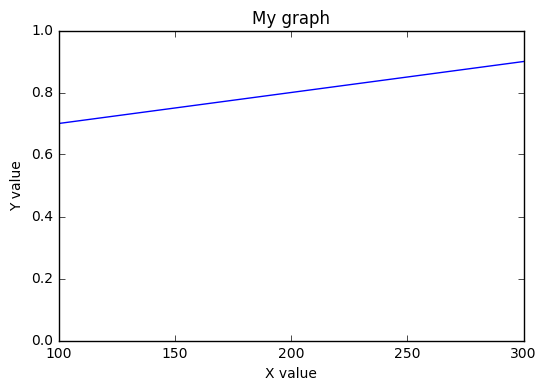

In [59]:
#plt.plot([1,2], [3,4])
plt.plot([100, 200, 300], [0.7, 0.8, 0.9], label="clf")
plt.xlabel("X value")
plt.ylabel("Y value")
plt.title("My graph")
plt.xlim(100,300)
plt.ylim(0,1)

In [12]:
from sklearn import naive_bayes


In [13]:
s = "abss(a:,a:)"
s.split("(")[0]

'abss'

## Parametric
1. Logistic Regression 

## Non-parametric 
1. Decision Trees 
2. K-nearest neighbors

In [61]:
def performance_metric(y_true, y_predict):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Print and return results
    #print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(y_true=y_true, y_pred=y_predict, pos_label='yes')


In [62]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y, clf, params):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(estimator=clf, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [63]:
X_train_300 = X_train
y_train_300 = y_train

In [16]:
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

X_train_100 = X_train[0:100]
y_train_100 = y_train[0:100]

X_train_200 = X_train[0:200]
y_train_200 = y_train[0:200]

X_train_300 = X_train
y_train_300 = y_train

finalized_classifiers = []

## Parametric 
# Gaussian Naive Bayes (GaussianNB)
g_nb = GaussianNB()
finalized_classifiers.append(g_nb)

# Decision Trees
tree = fit_model(X_train_300, y_train_300, 
                 DecisionTreeClassifier(random_state=0),
                 {'max_depth':range(1, 11), 'min_samples_split':range(2, 11), 'criterion':['gini', 'entropy']})
finalized_classifiers.append(tree)

# AdaBoost
ada = fit_model(X_train_300, y_train_300,
                AdaBoostClassifier(),
                {'n_estimators':range(1, 21) })
finalized_classifiers.append(ada)

# Random Forest
random_forest = fit_model(X_train_300, y_train_300, 
                          RandomForestClassifier(random_state=0, max_depth=6, criterion='entropy'),
                          {'n_estimators':range(2, 16), 'min_samples_split':range(2, 11)})
finalized_classifiers.append(random_forest)

# Gradient Boosting
gradient = fit_model(X_train_300, y_train_300, 
                     GradientBoostingClassifier(max_depth=1),
                     {'n_estimators':[100, 200, 300, 400, 500], 'learning_rate':[0.1, 0.4, 0.8]})
finalized_classifiers.append(gradient)

# K-Nearest Neighbors (KNeighbors)
neigh = KNeighborsClassifier(weights='distance', n_neighbors=10)
finalized_classifiers.append(neigh)


In [17]:
inprogress_classifiers = []

# Support Vector Machines (SVM)
svc = fit_model(X_train_300, y_train_300, 
                SVC(kernel='rbf'),
                {'C':np.logspace(-2, 10, 13), 'gamma':np.logspace(-9, 3, 13)})
inprogress_classifiers.append(svc)

# Stochastic Gradient Descent (SGDC)
sgdc = SGDClassifier(n_iter=10000)
inprogress_classifiers.append(sgdc)

# Logistic Regression
# Is it really a classifier ? YES.
l_reg = LogisticRegression()
inprogress_classifiers.append(l_reg)

# Bagging
bag = fit_model(X_train_300, y_train_300, BaggingClassifier(base_estimator=neigh),
                          {'n_estimators':[10, 20]}) 
inprogress_classifiers.append(bag)


In [18]:
np.logspace(-2, 10, 13)
np.logspace(-9, 3, 13)

array([  1.00000000e-09,   1.00000000e-08,   1.00000000e-07,
         1.00000000e-06,   1.00000000e-05,   1.00000000e-04,
         1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02,
         1.00000000e+03])

In [19]:
classifiers = finalized_classifiers + inprogress_classifiers
for cl in classifiers:
    print cl

GaussianNB()
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=None)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=1, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimator

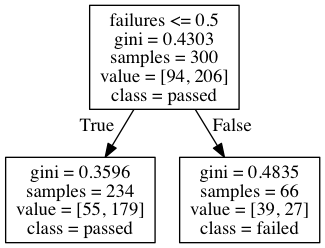

In [20]:
import sklearn.tree as t
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image
dot_data = StringIO()
t.export_graphviz(tree,  out_file=dot_data, feature_names=list(X_all.columns), class_names=['failed', 'passed'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [21]:
def run_and_plot():
    fig = plt.figure(figsize=(20,20))
    for index, clf in enumerate(classifiers):
        tr_acc_100,test_acc_100 = train_predict(clf, X_train_100, y_train_100, X_test, y_test)
        tr_acc_200,test_acc_200 = train_predict(clf, X_train_200, y_train_200, X_test, y_test)
        tr_acc_300,test_acc_300 = train_predict(clf, X_train_300, y_train_300, X_test, y_test)
        clf_label = (str(clf)).split("(")[0]
        print clf_label, test_acc_300, test_acc_200
        ax = fig.add_subplot((len(classifiers)/3)+1, 3,  index+1)
        ax.plot([100, 200, 300], [tr_acc_100, tr_acc_200, tr_acc_300], label="Training Acc of " + clf_label)
        ax.plot([100, 200, 300], [test_acc_100, test_acc_200, test_acc_300], label="Testing Acc of " + clf_label)
        ax.legend(loc=0)
        ax.set_ylim([-0.05, 1.05])
        ax.set_xlim([100, 300])

GaussianNB 0.75 0.713178294574
DecisionTreeClassifier 0.802919708029 0.802919708029
AdaBoostClassifier 0.8 0.791366906475
RandomForestClassifier 0.794520547945 0.780821917808
GradientBoostingClassifier 0.783216783217 0.785714285714
KNeighborsClassifier 0.783216783217 0.742857142857
SVC 0.791946308725 0.776315789474
SGDClassifier 0.765957446809 0.72380952381
LogisticRegression 0.791044776119 0.779411764706
BaggingClassifier 0.755244755245 0.741258741259


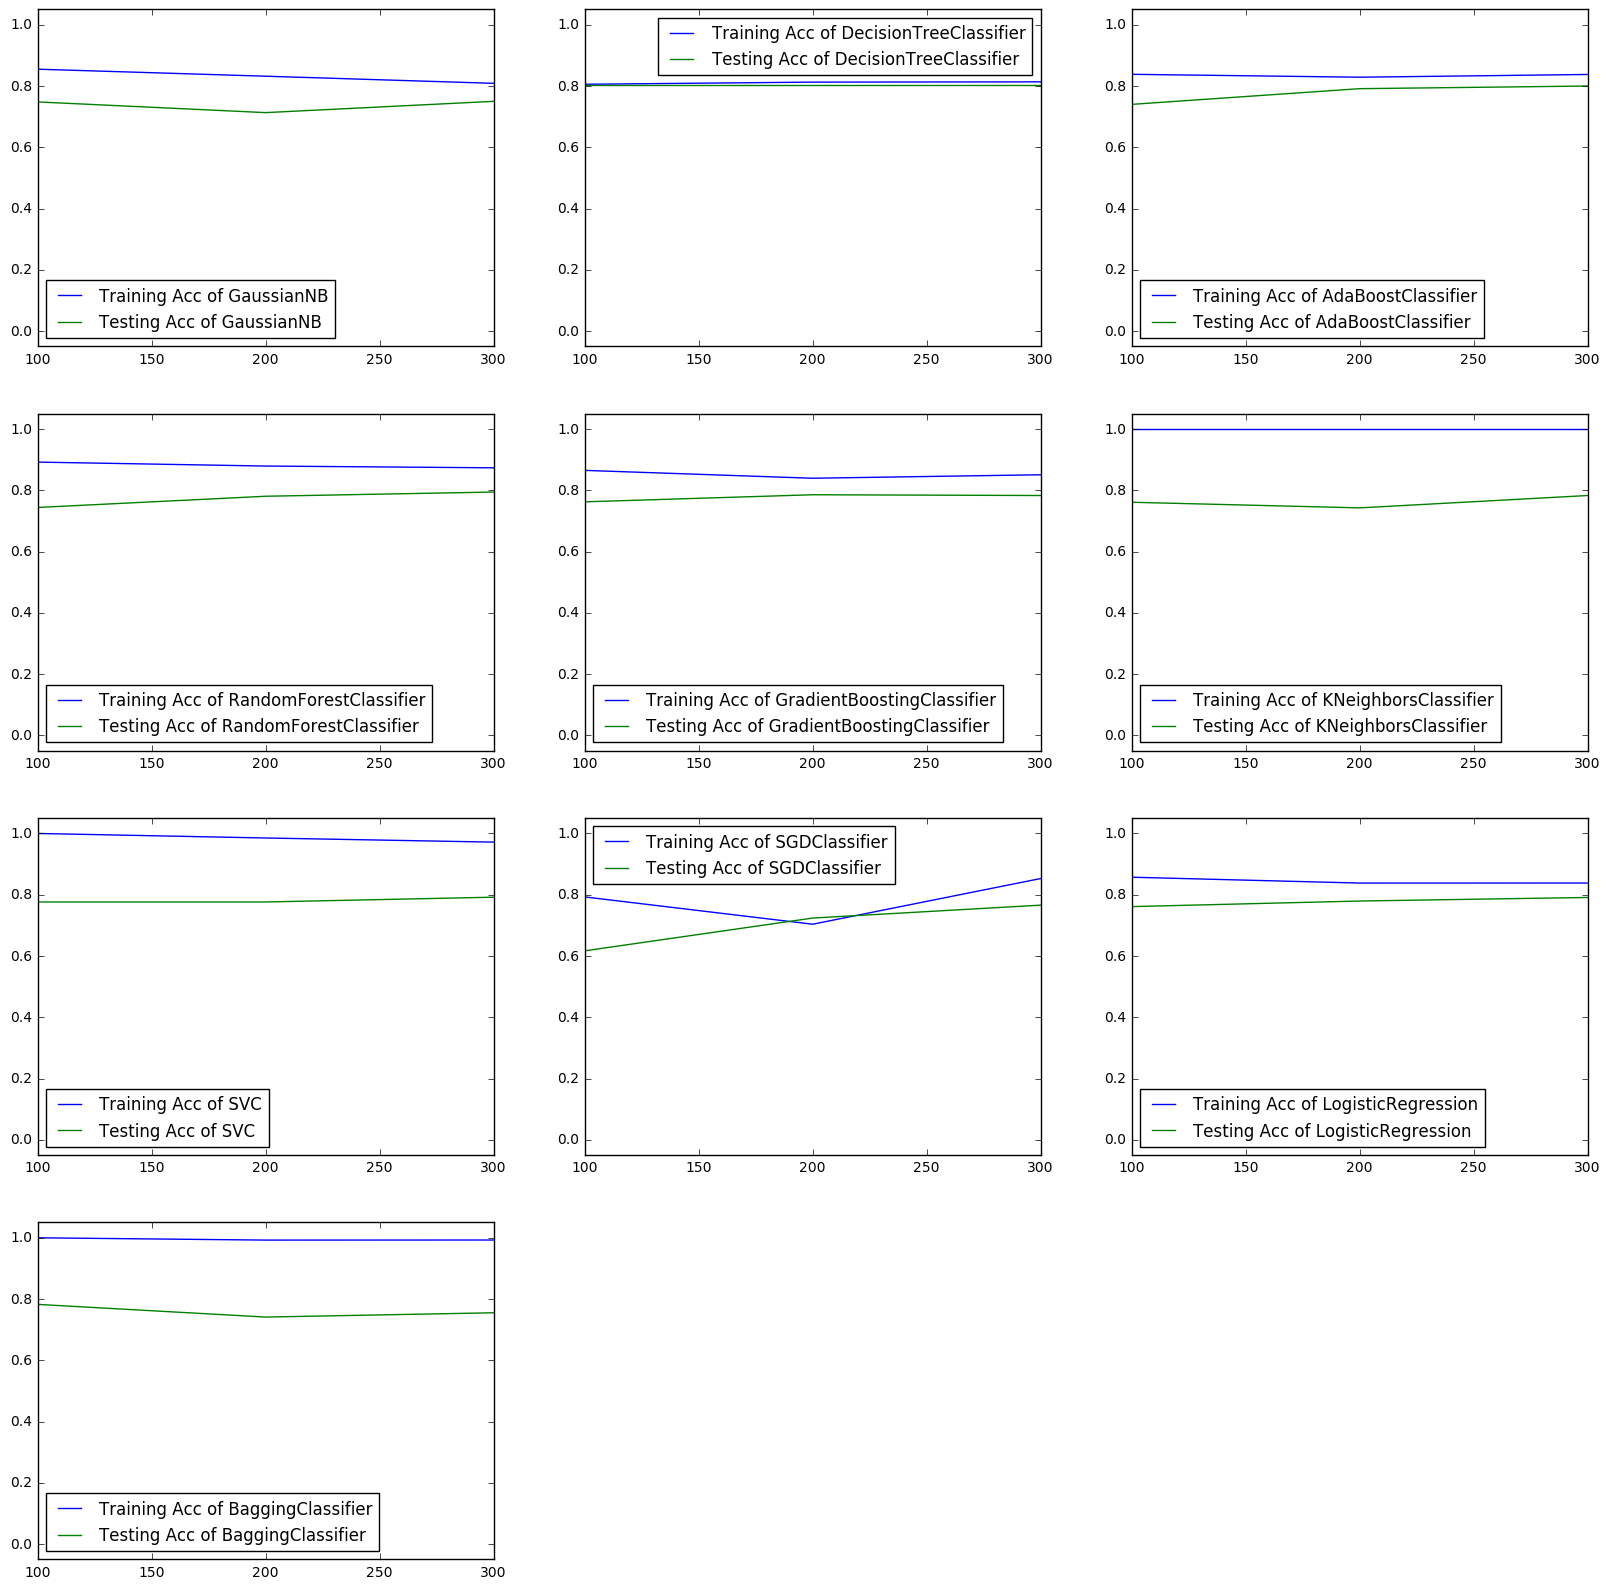

In [22]:
run_and_plot()

In [64]:
y_train_300

63      no
245    yes
154    yes
311    yes
81     yes
344    yes
336    yes
124     no
250     no
89      no
181    yes
21     yes
170     no
206     no
173     no
49      no
358    yes
196    yes
92      no
221     no
218     no
355     no
134     no
175     no
22     yes
241    yes
122    yes
176    yes
162     no
145    yes
      ... 
243    yes
115    yes
265    yes
72      no
333     no
25      no
165    yes
337     no
379    yes
174     no
381     no
39     yes
193    yes
314    yes
88     yes
70     yes
87     yes
292    yes
242     no
277     no
211    yes
9      yes
359    yes
195    yes
251    yes
323    yes
192     no
117    yes
47     yes
172    yes
Name: passed, dtype: object

In [73]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X_train_300)
#X=X_train_300
y=y_train_300
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(y, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(labels=['no' 'yes' ..., 'yes' 'yes'], n_iter=5, test_size=0.2, random_state=42),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [74]:
scores = [x[1] for x in grid.grid_scores_]

In [75]:
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

In [76]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

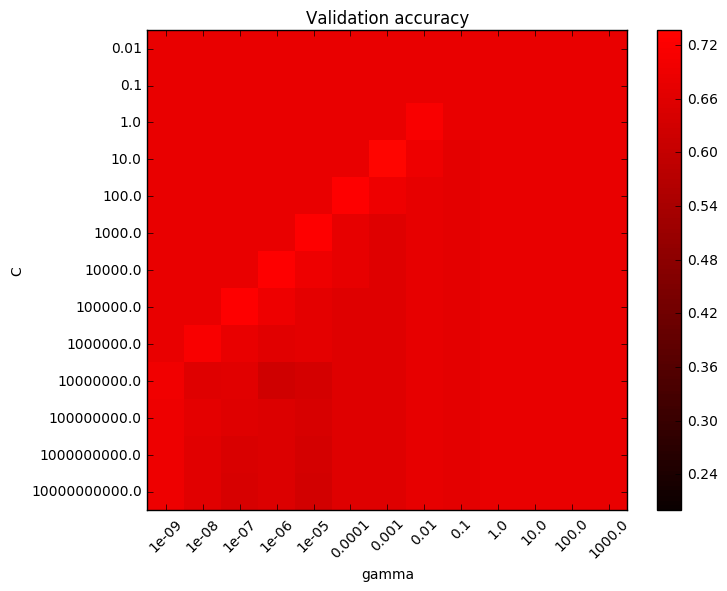

In [77]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [78]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
grid.best_estimator_
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)

The best parameters are {'C': 10.0, 'gamma': 0.001} with a score of 0.74


In [ ]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)

In [30]:
np.logspace(-2, 10, 13)

array([  1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
         1.00000000e+01,   1.00000000e+02,   1.00000000e+03,
         1.00000000e+04,   1.00000000e+05,   1.00000000e+06,
         1.00000000e+07,   1.00000000e+08,   1.00000000e+09,
         1.00000000e+10])

GaussianNB 0.75 0.713178294574
DecisionTreeClassifier 0.802919708029 0.802919708029
AdaBoostClassifier 0.8 0.791366906475
RandomForestClassifier 0.794520547945 0.780821917808
GradientBoostingClassifier 0.783216783217 0.785714285714
KNeighborsClassifier 0.783216783217 0.742857142857
SVC 0.791946308725 0.776315789474
SGDClassifier 0.759124087591 0.771428571429
LogisticRegression 0.791044776119 0.779411764706
BaggingClassifier 0.762589928058 0.785714285714


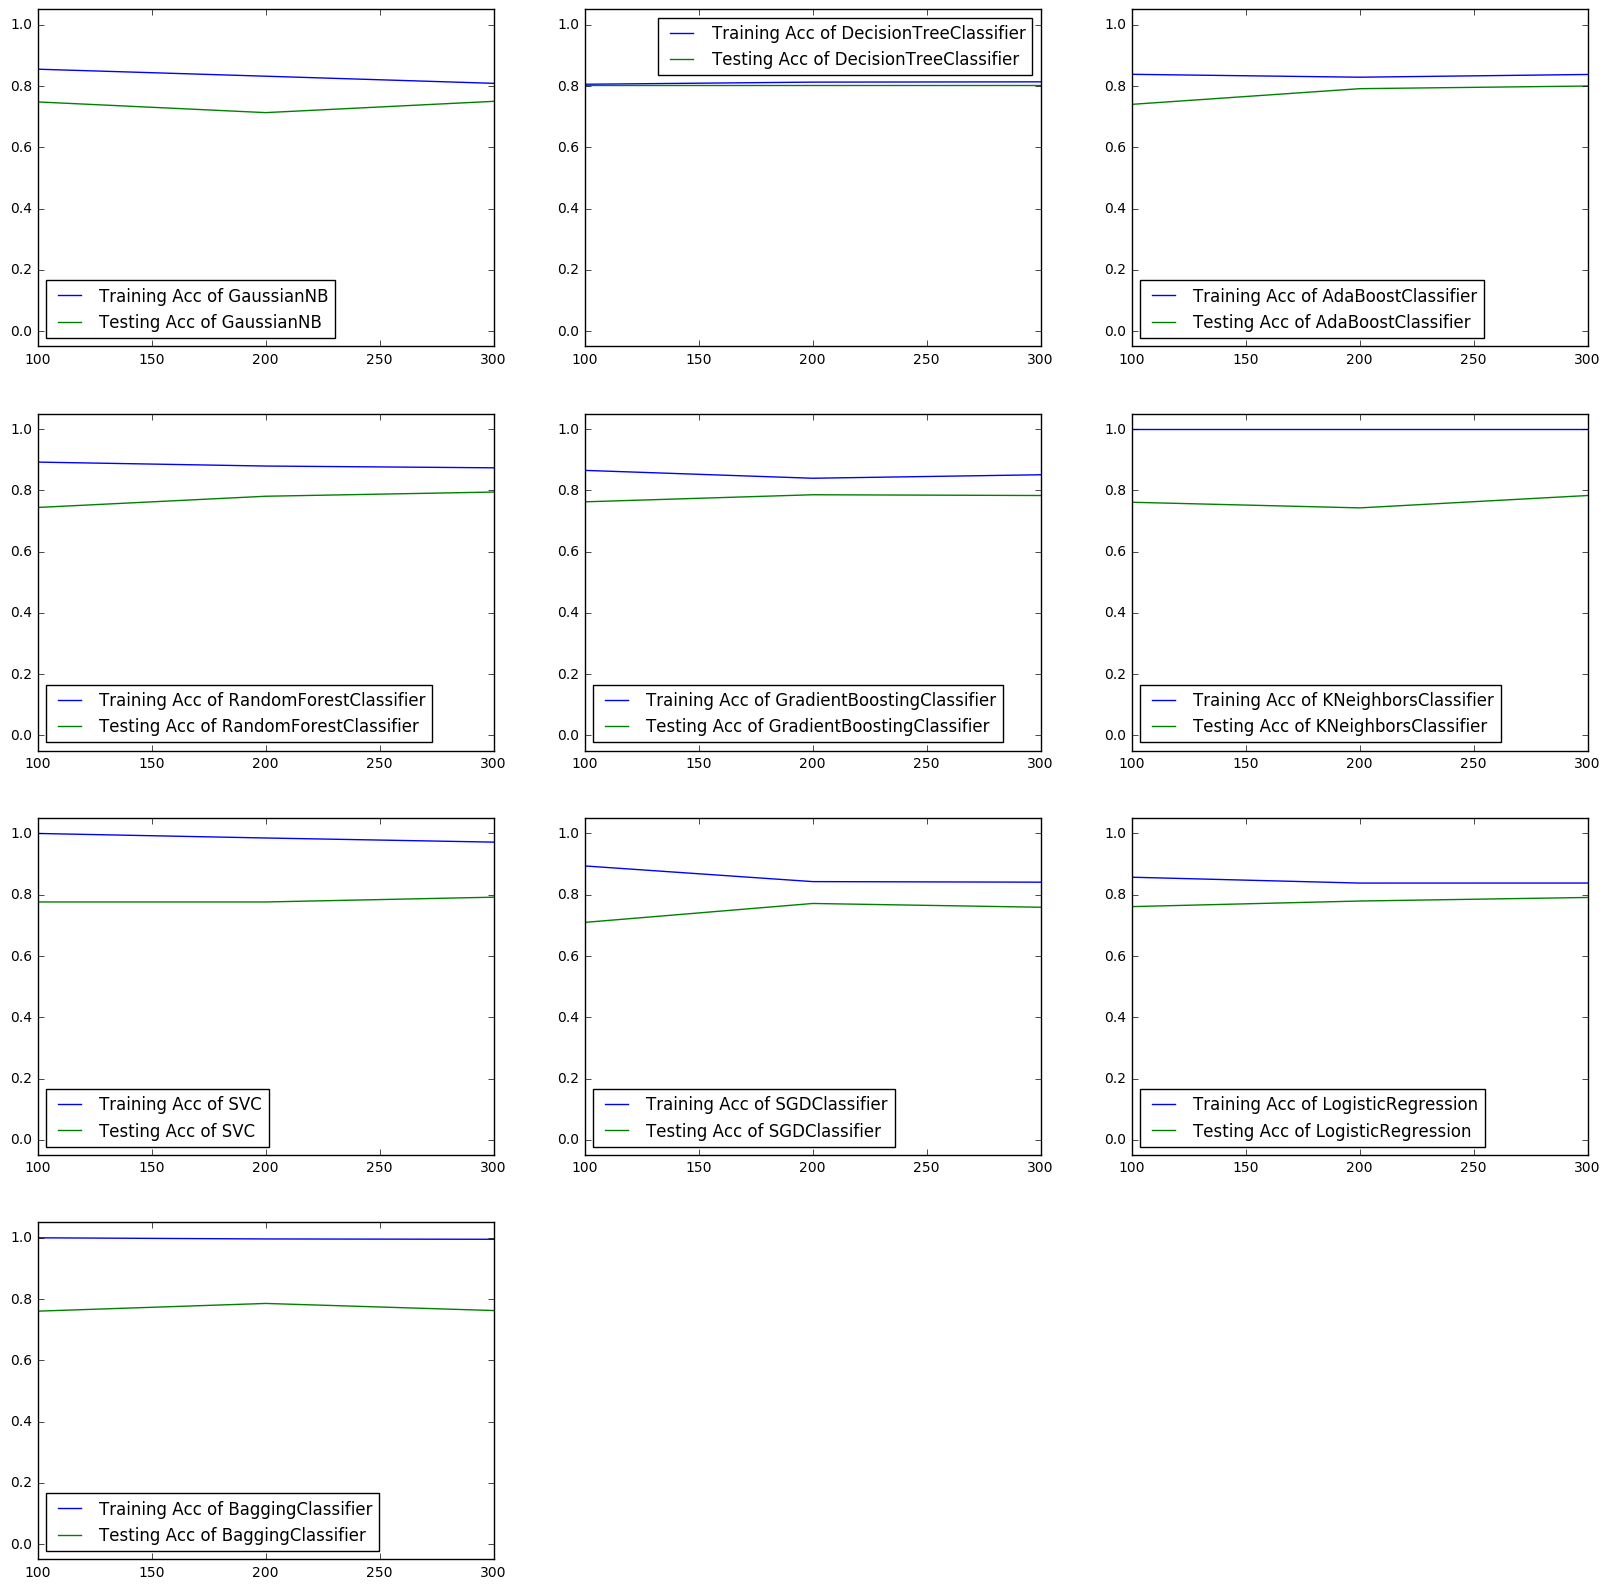

In [24]:
run_and_plot()

GaussianNB 0.75 0.713178294574
DecisionTreeClassifier 0.802919708029 0.802919708029
AdaBoostClassifier 0.8 0.791366906475
RandomForestClassifier 0.794520547945 0.780821917808
GradientBoostingClassifier 0.783216783217 0.785714285714
KNeighborsClassifier 0.783216783217 0.742857142857
SVC 0.791946308725 0.776315789474
SGDClassifier 0.778625954198 0.771428571429
LogisticRegression 0.791044776119 0.779411764706
BaggingClassifier 0.785714285714 0.762589928058


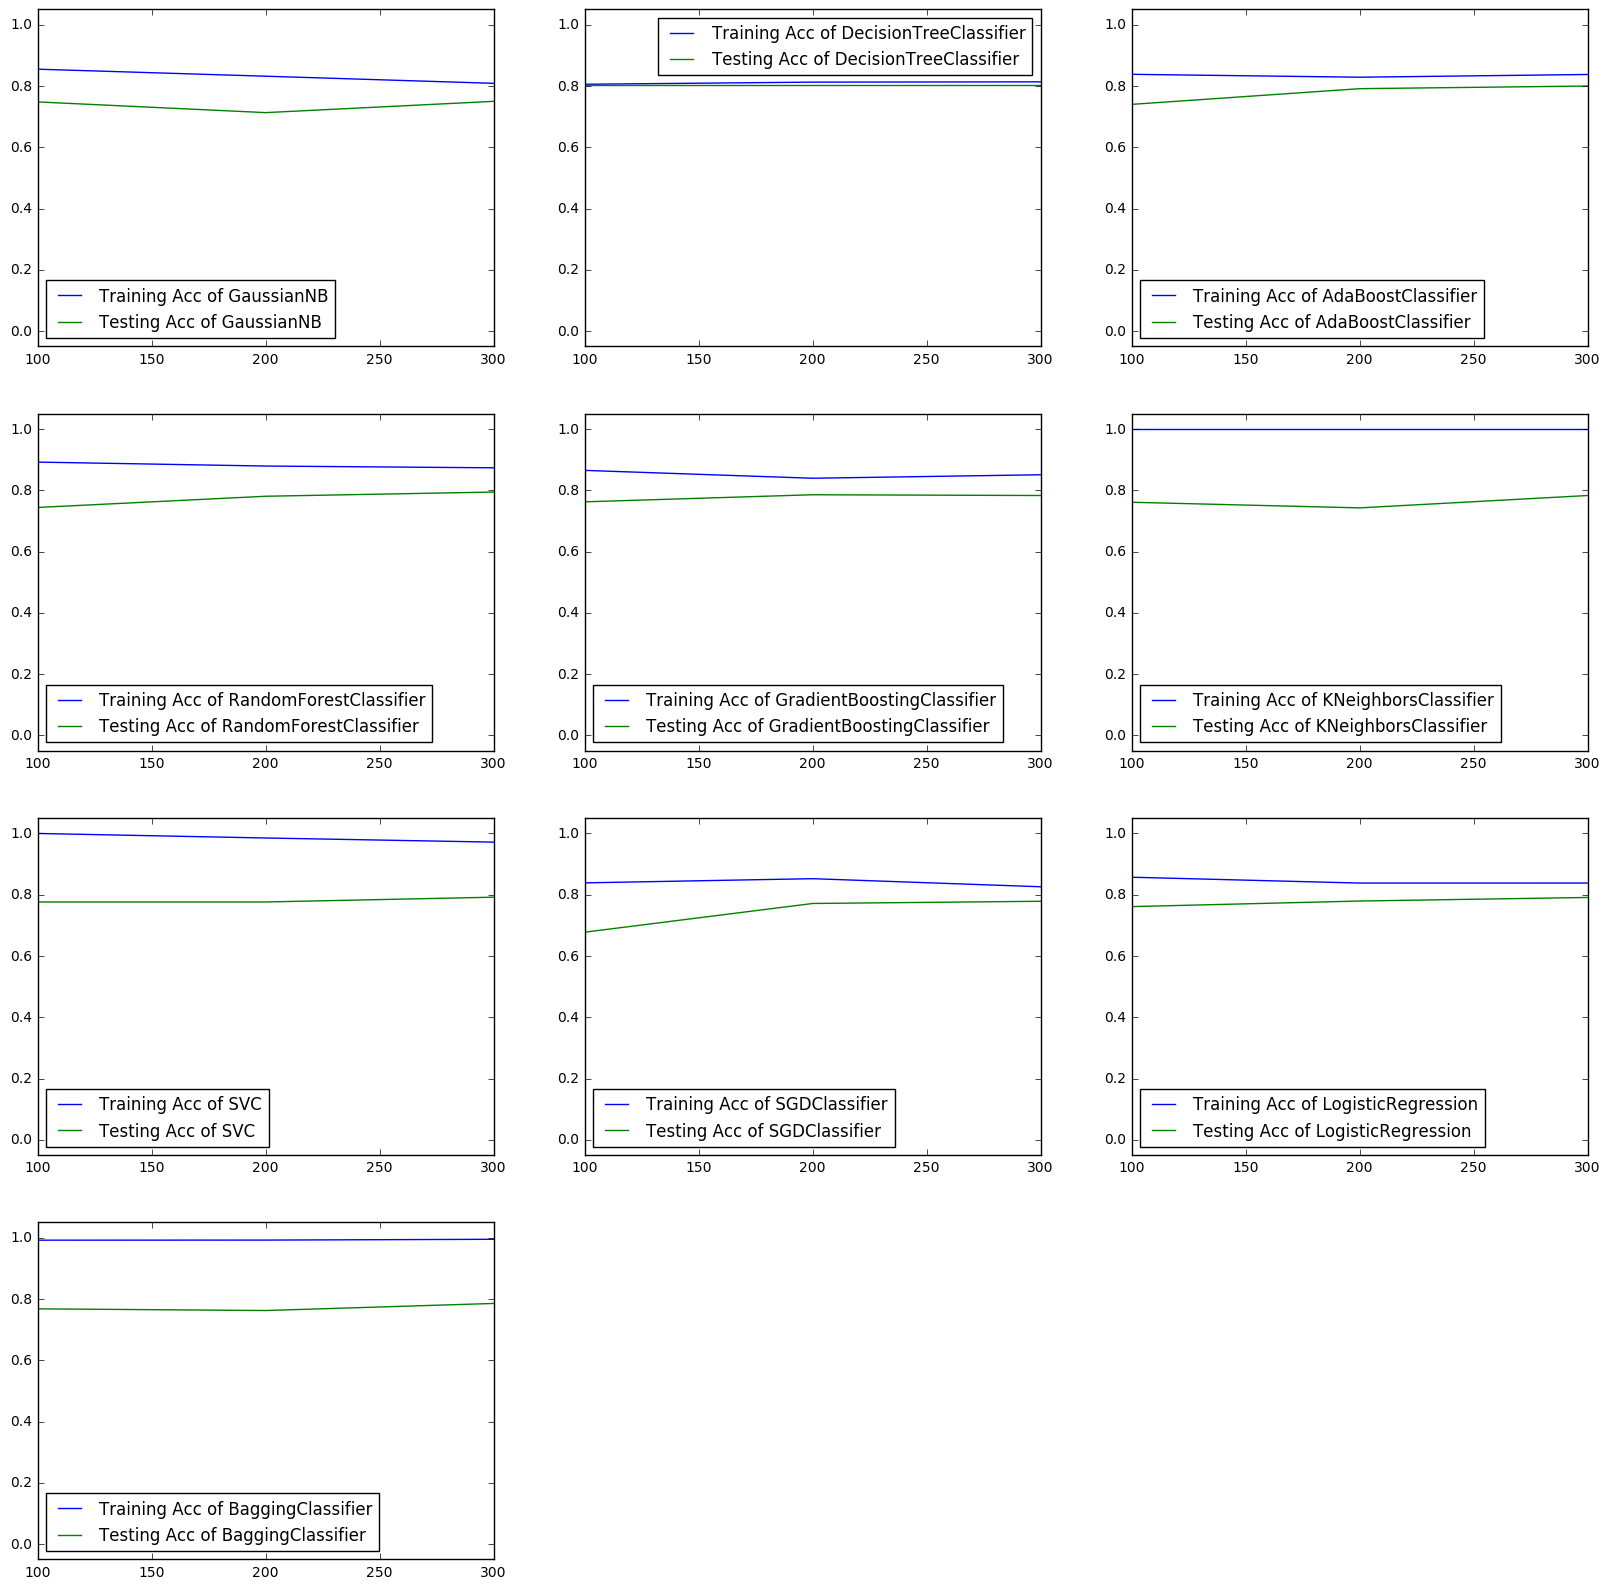

In [25]:
run_and_plot()

In [26]:
# TODO: Import the three supervised learning models from sklearn
# from sklearn import model_A
# from sklearn import model_B
# from sklearn import model_C

# TODO: Initialize the three models
clf_A = None
clf_B = None
clf_C = None

# TODO: Set up the training set sizes
X_train_100 = None
y_train_100 = None

X_train_200 = None
y_train_200 = None

X_train_300 = None
y_train_300 = None

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - ?**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |                         |                        |                  |                 |
| 200               |        EXAMPLE          |                        |                  |                 |
| 300               |                         |                        |                  |    EXAMPLE      |

** Classifer 2 - ?**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |                         |                        |                  |                 |
| 200               |     EXAMPLE             |                        |                  |                 |
| 300               |                         |                        |                  |     EXAMPLE     |

** Classifer 3 - ?**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |                         |                        |                  |                 |
| 200               |                         |                        |                  |                 |
| 300               |                         |                        |                  |                 |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [27]:
# TODO: Import 'GridSearchCV' and 'make_scorer'

# TODO: Create the parameters list you wish to tune
parameters = None

# TODO: Initialize the classifier
clf = None

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = None

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = None

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = None

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

AttributeError: 'NoneType' object has no attribute 'best_estimator_'

### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.